## 0. Import packages

In [1]:
import pandas as pd
import gzip
import math
from tqdm import tqdm
from itertools import chain, combinations
from Association import Association
from math import sqrt
tqdm.pandas() #for progres_apply etc.

## 1. Load data from previous step

In [2]:
seed_index = 2

In [3]:
import pickle
train_df = pickle.load(open(f"pickle_dumps/train_df_{seed_index}.p", "rb"))
tests_df = pickle.load(open(f"pickle_dumps/test_df_{seed_index}.p", "rb"))

article_train_df = pickle.load(open(f"pickle_dumps/article_train_df_{seed_index}.p", "rb"))
article_test_df = pickle.load(open(f"pickle_dumps/article_test_df_{seed_index}.p", "rb"))

In [4]:
train_df

,item_id,user_id
0,"[1461, 1999, 1984, 761, 2820, 819, 187, 506, 3...",0
1,"[4014, 1018, 3632, 2843, 2755, 219, 6245, 2621...",1
2,"[886, 2010, 419, 2217, 1293, 2809, 802, 155, 2...",2
3,"[1849, 1038, 229, 400, 1386, 1437, 1363, 515, ...",3
4,"[2883, 401, 2243, 4408, 3966, 1487, 1888, 2708...",4
...,...,...
54185,[122],54185
54186,[27],54186
54187,[1],54187
54188,[47],54188


If we plot a disrtibution of the length per user, we see that most data leans towards a length of 100 items

25.977265178077136


(array([2.9117e+04, 1.0381e+04, 5.7540e+03, 2.8750e+03, 1.7350e+03,
        1.0580e+03, 7.6600e+02, 4.9900e+02, 4.1000e+02, 2.9600e+02,
        2.4200e+02, 1.8100e+02, 1.2900e+02, 1.0600e+02, 9.2000e+01,
        6.1000e+01, 7.0000e+01, 4.6000e+01, 3.7000e+01, 4.7000e+01,
        3.6000e+01, 2.5000e+01, 2.3000e+01, 2.2000e+01, 1.6000e+01,
        1.7000e+01, 1.4000e+01, 1.0000e+01, 1.2000e+01, 1.2000e+01,
        9.0000e+00, 1.2000e+01, 1.2000e+01, 6.0000e+00, 9.0000e+00,
        6.0000e+00, 2.0000e+00, 0.0000e+00, 9.0000e+00, 3.0000e+00,
        2.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+01, 4.0000e+00,
        1.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([  1.  ,  14.46,  27.92,  41.38,  54.84,  68.3 ,  81.76,  95.22,
        108.68, 122.14, 135.6 , 149.06, 162.52, 175.98, 189.44, 202.9 ,
        216.36, 229.82, 243.28, 256.74, 270.2 , 283.66, 297.12, 310.58,
        324.04, 337.5 , 350.96, 364.42, 377.88, 391.34, 404.8 , 418.26,
        431.72, 445.18, 458.64

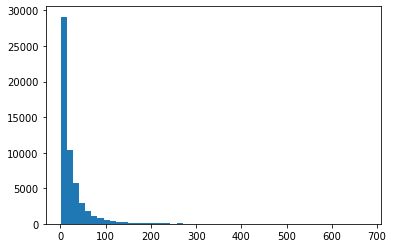

In [5]:
import matplotlib.pyplot as plt
x = [len(i) for i in train_df["item_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [6]:
article_train_df

,item_id,user_id
0,1461,"[0, 10, 11, 18, 19, 20, 22, 23, 29, 30, 32, 35..."
1,1999,"[0, 4, 5, 7, 12, 14, 23, 24, 38, 44, 49, 51, 5..."
2,1984,"[0, 3, 11, 12, 14, 20, 22, 27, 28, 29, 30, 32,..."
3,761,"[0, 2, 3, 11, 14, 15, 27, 28, 34, 38, 41, 44, ..."
4,2820,"[0, 2, 3, 6, 16, 64, 188, 222, 287, 317, 377, ..."
...,...,...
7032,7117,[45284]
7033,7060,[47157]
7034,7213,[47246]
7035,7254,[49357]


The transposed dataframe that is used for building user association rules has only a few items most of the time. this is not that important because of the way user associations are build.

200.04376865141396


(array([5.131e+03, 6.040e+02, 3.100e+02, 1.630e+02, 1.370e+02, 9.800e+01,
        6.800e+01, 7.100e+01, 6.300e+01, 3.400e+01, 3.400e+01, 3.000e+01,
        2.200e+01, 2.100e+01, 2.400e+01, 2.800e+01, 2.100e+01, 1.300e+01,
        1.800e+01, 1.600e+01, 8.000e+00, 6.000e+00, 1.200e+01, 9.000e+00,
        1.000e+01, 8.000e+00, 1.000e+00, 6.000e+00, 1.000e+00, 1.000e+00,
        1.100e+01, 6.000e+00, 5.000e+00, 1.000e+00, 4.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 6.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 6.000e+00]),
 array([1.00000e+00, 1.04220e+02, 2.07440e+02, 3.10660e+02, 4.13880e+02,
        5.17100e+02, 6.20320e+02, 7.23540e+02, 8.26760e+02, 9.29980e+02,
        1.03320e+03, 1.13642e+03, 1.23964e+03, 1.34286e+03, 1.44608e+03,
        1.54930e+03, 1.65252e+03, 1.75574e+03, 1.85896e+03, 1.96218e+03,
        2.06540e+03, 2.16862e+03, 2.27184e+03, 2.37506e+03, 2.47828e+03,
        2.5

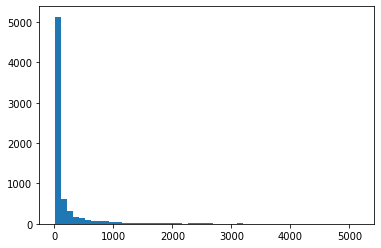

In [7]:
x = [len(i) for i in article_train_df["user_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [8]:
tests_df

,item_id,user_id
0,"[4172, 1833, 107, 803, 3272, 243, 403, 1920, 2...",0
1,"[366, 1127, 60, 613, 274, 865, 1559, 1849, 263...",1
2,"[913, 8, 1995, 963, 656, 232, 1999, 1586, 642,...",2
3,"[1250, 378, 2427, 622, 1392, 67, 2972, 2943, 8...",3
4,"[2860, 671, 1075, 3862, 2971, 562, 2753, 1833,...",4
...,...,...
54185,[45],54185
54186,[4],54186
54187,[497],54187
54188,[32],54188


In [9]:
data = train_df.set_index("user_id").to_dict()["item_id"]
article_data = article_train_df.set_index("item_id").to_dict()["user_id"]

test_users = tests_df["user_id"].tolist()

## 2. Functions or building association rules

In [10]:
def convertTo(df):
    with open("eclat_in.txt", "w") as f:
        tmp = df.items()
        for item in tmp:
            s = ' '.join([str(elem) for elem in item[1]])
            f.write(s + "\n")
            

def convertFrom():
    res = []
    with open("eclat_out.txt", "r") as f:
        for line in f:
            try:
                tmp = line.strip()
                tmp = tmp.split(" <- ")
                consequent = [tmp[0]]
                tmp = tmp[1].split(" (")
                antecedent = tmp[0].split(" ")
                tmp = tmp[1].strip(')').split(", ")
                sup = tmp[0]
                conf = tmp[1]
                lift = tmp[2]
                z = tmp[3]
                antecedent = list(map(int, antecedent))
                consequent = list(map(int, consequent))
                res.append(Association(antecedent, consequent, float(conf), float(sup), 
                                       float(lift), float(z)))
            except:
                pass
    
    return res

In [11]:
def genRules(min_conf, minsup, df):
    print("---writing data---")
    convertTo(df)
    print("---building rules---")
    !eclat -tr -Z -s-$minsup -c$min_conf -el -v" (%s, %c, %l, %e)" eclat_in.txt eclat_out.txt
    print("---reading data---")
    rules = convertFrom()
    return rules

## 3. Build association rules

### Article association rules
Build rules of the form:
`Item1 and Item2 -> Item3`

In [12]:
%%time

print(len(data))

# Build the article association rules with a minimum support of 50 and minimum confidence of 0.85
raw_article_assos_rules = []
values = [(0,2000), (80,100), (50,333), (25,500)]
# values = [(0,1250), (80,50), (50,230), (25,200)]
for conf,sup in values:
    tmp = genRules(conf, sup, data)
    tmp = sorted(tmp, key=lambda x: x.s * x.c, reverse=True)[:1000000]
    print(len(tmp))
    raw_article_assos_rules.extend(tmp)
    print(len(raw_article_assos_rules))

54190
---writing data---
---building rules---
all: 796981
  0: 0
  1: 7037
  2: 753195
  3: 36749
---reading data---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7037 item(s), 54190 transaction(s)] done [0.08s].
filtering, sorting and recoding items ... [7037 item(s)] done [0.00s].
sorting and reducing transactions ... [51589/54190 transaction(s)] done [0.04s].
finding frequent item sets ... done [1.26s].
writing eclat_out.txt ... [796981 rule(s)] done [0.44s].


789944
789944
---writing data---
---building rules---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7037 item(s), 54190 transaction(s)] done [0.07s].
filtering, sorting and recoding items ... [2218 item(s)] done [0.00s].
sorting and reducing transactions ... [51460/54190 transaction(s)] done [0.03s].
finding frequent item sets ... done [8.96s].
writing eclat_out.txt ... [518 rule(s)] done [0.10s].


all: 518
  0: 0
  1: 0
  2: 0
  3: 34
  4: 360
  5: 119
  6: 5
---reading data---
518
790462
---writing data---
---building rules---
all: 15701
  0: 0
  1: 0
  2: 594
  3: 11058
  4: 3847
  5: 202
---reading data---
15701
806163
---writing data---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7037 item(s), 54190 transaction(s)] done [0.08s].
filtering, sorting and recoding items ... [1487 item(s)] done [0.00s].
sorting and reducing transactions ... [51274/54190 transaction(s)] done [0.02s].
finding frequent item sets ... done [1.63s].
writing eclat_out.txt ... [15701 rule(s)] done [0.02s].


---building rules---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7037 item(s), 54190 transaction(s)] done [0.07s].
filtering, sorting and recoding items ... [1743 item(s)] done [0.00s].
sorting and reducing transactions ... [51361/54190 transaction(s)] done [0.02s].
finding frequent item sets ... done [2.18s].
writing eclat_out.txt ... [91707 rule(s)] done [0.06s].


all: 91707
  0: 0
  1: 0
  2: 8972
  3: 78573
  4: 4136
  5: 25
  6: 1
---reading data---
91707
897870
Wall time: 22.6 s


In [13]:
len(raw_article_assos_rules)

897870

In [14]:
article_assos_rules = sorted(raw_article_assos_rules, key=lambda x: x.s * x.c, reverse=True)[:1000000]

In [15]:
len(article_assos_rules)

897870

In [16]:
%%time

# print number of rules with item 3 in the lhs
counter = 0
for r in article_assos_rules:
    if 3 in r.left:
        counter += 1
counter

Wall time: 331 ms


5947

In [17]:
# print number of rules with a support greater than 150
for r in article_assos_rules:
    if int(r.s) > 10000:
        print(r)

### User association rules
Build rules of the form: `User1 and User2 -> User3`

This builds rules that represent the relation and similarity between users.

In [18]:
%%time
# Build the user association rules with a minimum support and minimum confidence

raw_user_assos_rules = []
values = [(0,500), (25,125), (50,75), (80, 40)]
# values = [(0,400), (25,100), (50,75), (80, 40)]
for conf,sup in values:
    tmp = genRules(conf, sup, article_data)
    tmp = sorted(tmp, key=lambda x: x.s * x.c, reverse=True)
    print(len(tmp))
    raw_user_assos_rules.extend(tmp)
    print(len(raw_user_assos_rules))

---writing data---
---building rules---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [54190 item(s), 7037 transaction(s)] done [0.09s].
filtering, sorting and recoding items ... [54190 item(s)] done [0.00s].
sorting and reducing transactions ... [6790/7037 transaction(s)] done [0.02s].
finding frequent item sets ... done [29.09s].
writing eclat_out.txt ... [2041601 rule(s)] done [1.11s].


all: 2041601
  0: 0
  1: 54190
  2: 1987411
---reading data---
1987411
1987411
---writing data---
---building rules---
all: 883626
  0: 0
  1: 0
  2: 218797
  3: 652649
  4: 12180
---reading data---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [54190 item(s), 7037 transaction(s)] done [0.09s].
filtering, sorting and recoding items ... [12537 item(s)] done [0.01s].
sorting and reducing transactions ... [6629/7037 transaction(s)] done [0.01s].
finding frequent item sets ... done [10.14s].
writing eclat_out.txt ... [883626 rule(s)] done [0.62s].


883626
2871037
---writing data---
---building rules---
all: 969606
  0: 0
  1: 0
  2: 10267
  3: 374629
  4: 469469
  5: 114007
  6: 1234
---reading data---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [54190 item(s), 7037 transaction(s)] done [0.09s].
filtering, sorting and recoding items ... [10050 item(s)] done [0.00s].
sorting and reducing transactions ... [6569/7037 transaction(s)] done [0.01s].
finding frequent item sets ... done [12.23s].
writing eclat_out.txt ... [969606 rule(s)] done [0.69s].


969606
3840643
---writing data---
---building rules---


eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [54190 item(s), 7037 transaction(s)] done [0.09s].
filtering, sorting and recoding items ... [12537 item(s)] done [0.00s].
sorting and reducing transactions ... [6629/7037 transaction(s)] done [0.01s].
finding frequent item sets ... done [29.92s].
writing eclat_out.txt ... [874666 rule(s)] done [1.42s].


all: 874666
  0: 0
  1: 0
  2: 13
  3: 3457
  4: 25161
  5: 159212
  6: 651470
  7: 35300
  8: 53
---reading data---
874666
4715309
Wall time: 1min 49s


In [19]:
user_assos_rules = raw_user_assos_rules

In [20]:
# print numebr of generated rules
print(len(user_assos_rules))

4715309


See for how much test users we were able to create association rules and how many

In [21]:
%%time

corr = {}
user_d = {}
for r in tqdm(user_assos_rules):
    for user in list(r.right):
        if user in corr:
            corr[user] += 1
            user_d[user].append(r)
        else:
            corr[user] = 1
            user_d[user] = [r]

100%|██████████| 4715309/4715309 [00:04<00:00, 999428.03it/s] 

Wall time: 4.73 s


In [22]:
for user in user_d:
    user_d[user] = sorted(user_d[user], key=lambda x: x.s * x.c, reverse=True)[:10000]

In [23]:
print(len(test_users))
print(len(corr))
print(corr)

54190
54102
{105: 64721, 2: 27395, 81: 6970, 18: 8772, 11: 24001, 15: 13781, 28: 9953, 3: 15441, 14: 22829, 29: 17424, 6: 18886, 16: 17900, 25: 13038, 43: 5438, 135: 47899, 22: 19630, 0: 12502, 40: 7966, 30: 15579, 152: 22969, 12: 14088, 148: 122092, 10: 13586, 58: 18143, 103: 31213, 4: 5968, 181: 33246, 71: 49205, 21: 5350, 176: 45279, 193: 67879, 204: 26536, 1: 4543, 35: 8998, 46: 11132, 132: 32952, 213: 27627, 79: 9548, 94: 8300, 32: 4253, 34: 7369, 47: 5258, 59: 12026, 66: 10545, 7: 2798, 108: 8807, 8: 1809, 13: 3801, 48: 14117, 41: 11189, 17: 1316, 56: 21920, 20: 2381, 42: 6549, 5: 445, 52: 4591, 60: 2023, 50: 1732, 55: 4097, 75: 1978, 97: 3623, 106: 4195, 119: 23472, 83: 8585, 44: 5301, 257: 35375, 129: 8180, 292: 21775, 19: 2068, 53: 1254, 54: 6552, 62: 4583, 161: 3007, 9: 3916, 31: 350, 159: 4041, 338: 45205, 138: 8019, 78: 6526, 23: 2181, 90: 4669, 70: 3096, 163: 7664, 109: 5992, 27: 4008, 98: 4496, 155: 2860, 104: 3533, 327: 53366, 49: 3553, 158: 8462, 137: 8084, 201: 15314, 

In [24]:
total = 0
for u in user_d:
    total += len(user_d[u])
total

3574208

## 4. Normalize support / confidence to better use it later

## 5. Store the association rules as pickle file for further use

In [25]:
import pickle
pickle.dump(article_assos_rules, open(f"pickle_dumps/article_rules_{seed_index}.p", "wb"))
pickle.dump(user_d, open(f"pickle_dumps/user_rules_{seed_index}.p", "wb"))